In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import skimage.measure

from nionswift_plugin.usim.SampleSimulator import gaussian_superposition

from psm.libraries import load_library
from psm.structures.graphene import build_rectangular_graphene, insert_defect_graphene
from psm.structures.utils import rotate, fill_rectangle
from psm.graph import stable_delaunay_graph

from IPython.display import clear_output

In [2]:
def closest_points(point, other_points):
    return cdist([point], other_points).argmin()

In [14]:
library, alias = load_library('graphene')

for defect in library.values():
    if defect.labels is None:
        defect.set_labels(np.zeros(len(defect), np.int))
print(library.keys())
library = {key : library[key] for key in ['0.1.6-6-6.13.json', '1.1.5-5_6-6.15.json']}
library['0.1.6-6-6.13-2.json'] = library['0.1.6-6-6.13.json']

dict_keys(['-2.0.5-5-5_6_7-7-7.24.json', '0.0.5-5_7-7.16.json', '0.1.6-6-6.13.json', '1.0.5_8.12.json', '1.1.5-5_6-6.15.json', '1.1.5-5_8.15.json', '10.0.5-5-5-5-5-5-5-5_6_7-7_8-8-8.49.json', '2.0.5-5-5-5_6_7-7-7-7.30.json', '2.0.5-5-5_7-7-7.22.json', '2.0.5-5_7-7.18.json', '2.0.5-5_8.14.json', '3.0.5-5_7-7.19.json', '3.0.5-5_9.16.json', '3.1.4_5-5_8-8.23.json', '4.0.4_5-5_8-8.22.json', '4.0.5-5-5-5-5-5_6-6-6-6_7-7-7-7-7-7.48.json', '4.0.5-5-5-5-5_6_7-7-7-7-7.38.json', '4.0.5-5-5-5_6_7-7_8.29.json', '4.0.5-5-5-5_7-7_8.28.json', '4.0.5-5-5-5_8-8.24.json', '6.0.4-4_5-5_8-8-8.30.json', '6.0.5-5-5-5-5_6-6_7-7-7-7-7.40.json'])


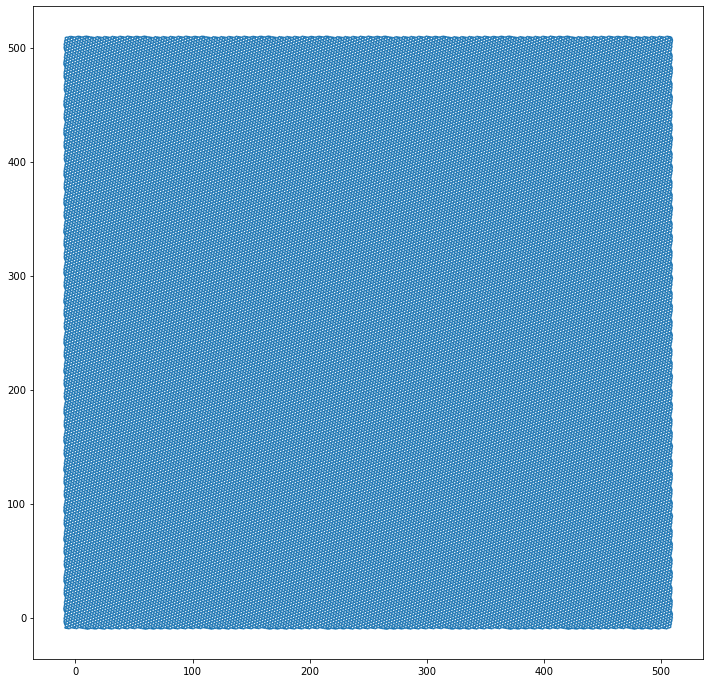

In [12]:
points, cell = build_rectangular_graphene(n=2, m=1)
points, cell = rotate(points, 20, cell, rotate_cell=True)
points, cell = fill_rectangle(points, cell, (500, 500), margin=10)

graph = stable_delaunay_graph(points, 2)
graph.set_labels(np.zeros(len(graph), np.int))

fig,ax=plt.subplots(figsize=(12,12))
graph.plot(ax=ax)

In [15]:
target_num_defects = 150 # should fit in the sample, other it will loop infinitely
keys = list(library.keys())
dual = graph.dual()

i = 0
while i < target_num_defects:
    defect_key = keys[np.random.randint(len(keys))]
    defect_graph = library[defect_key]
    defect_position = [np.random.rand() * 500, np.random.rand() * 500]
    seed = closest_points(defect_position, dual.points)
    
    try:
        graph = insert_defect_graphene(graph, defect_graph, seed, np.random.randint(6))
        i += 1
        print('{} defects inserted'.format(i))
        clear_output(wait=True)
    except (RuntimeError, KeyError, ZeroDivisionError): # possible exceptions on overlapping defects
        pass

150 defects inserted


In [37]:
dual = graph.dual()

In [38]:
defect_graph = library['1.1.5-5_6-6.15.json']
seed = closest_points((240,260), dual.points)
graph = insert_defect_graphene(graph, defect_graph, seed, np.random.randint(6))

In [13]:
#defect_graph.plot()

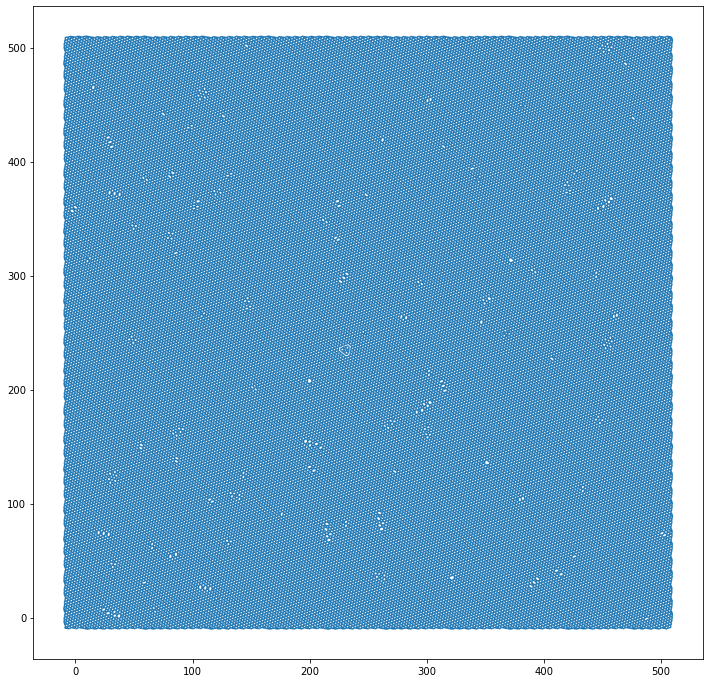

In [20]:
fig,ax=plt.subplots(figsize=(12,12))
graph.plot(ax=ax)

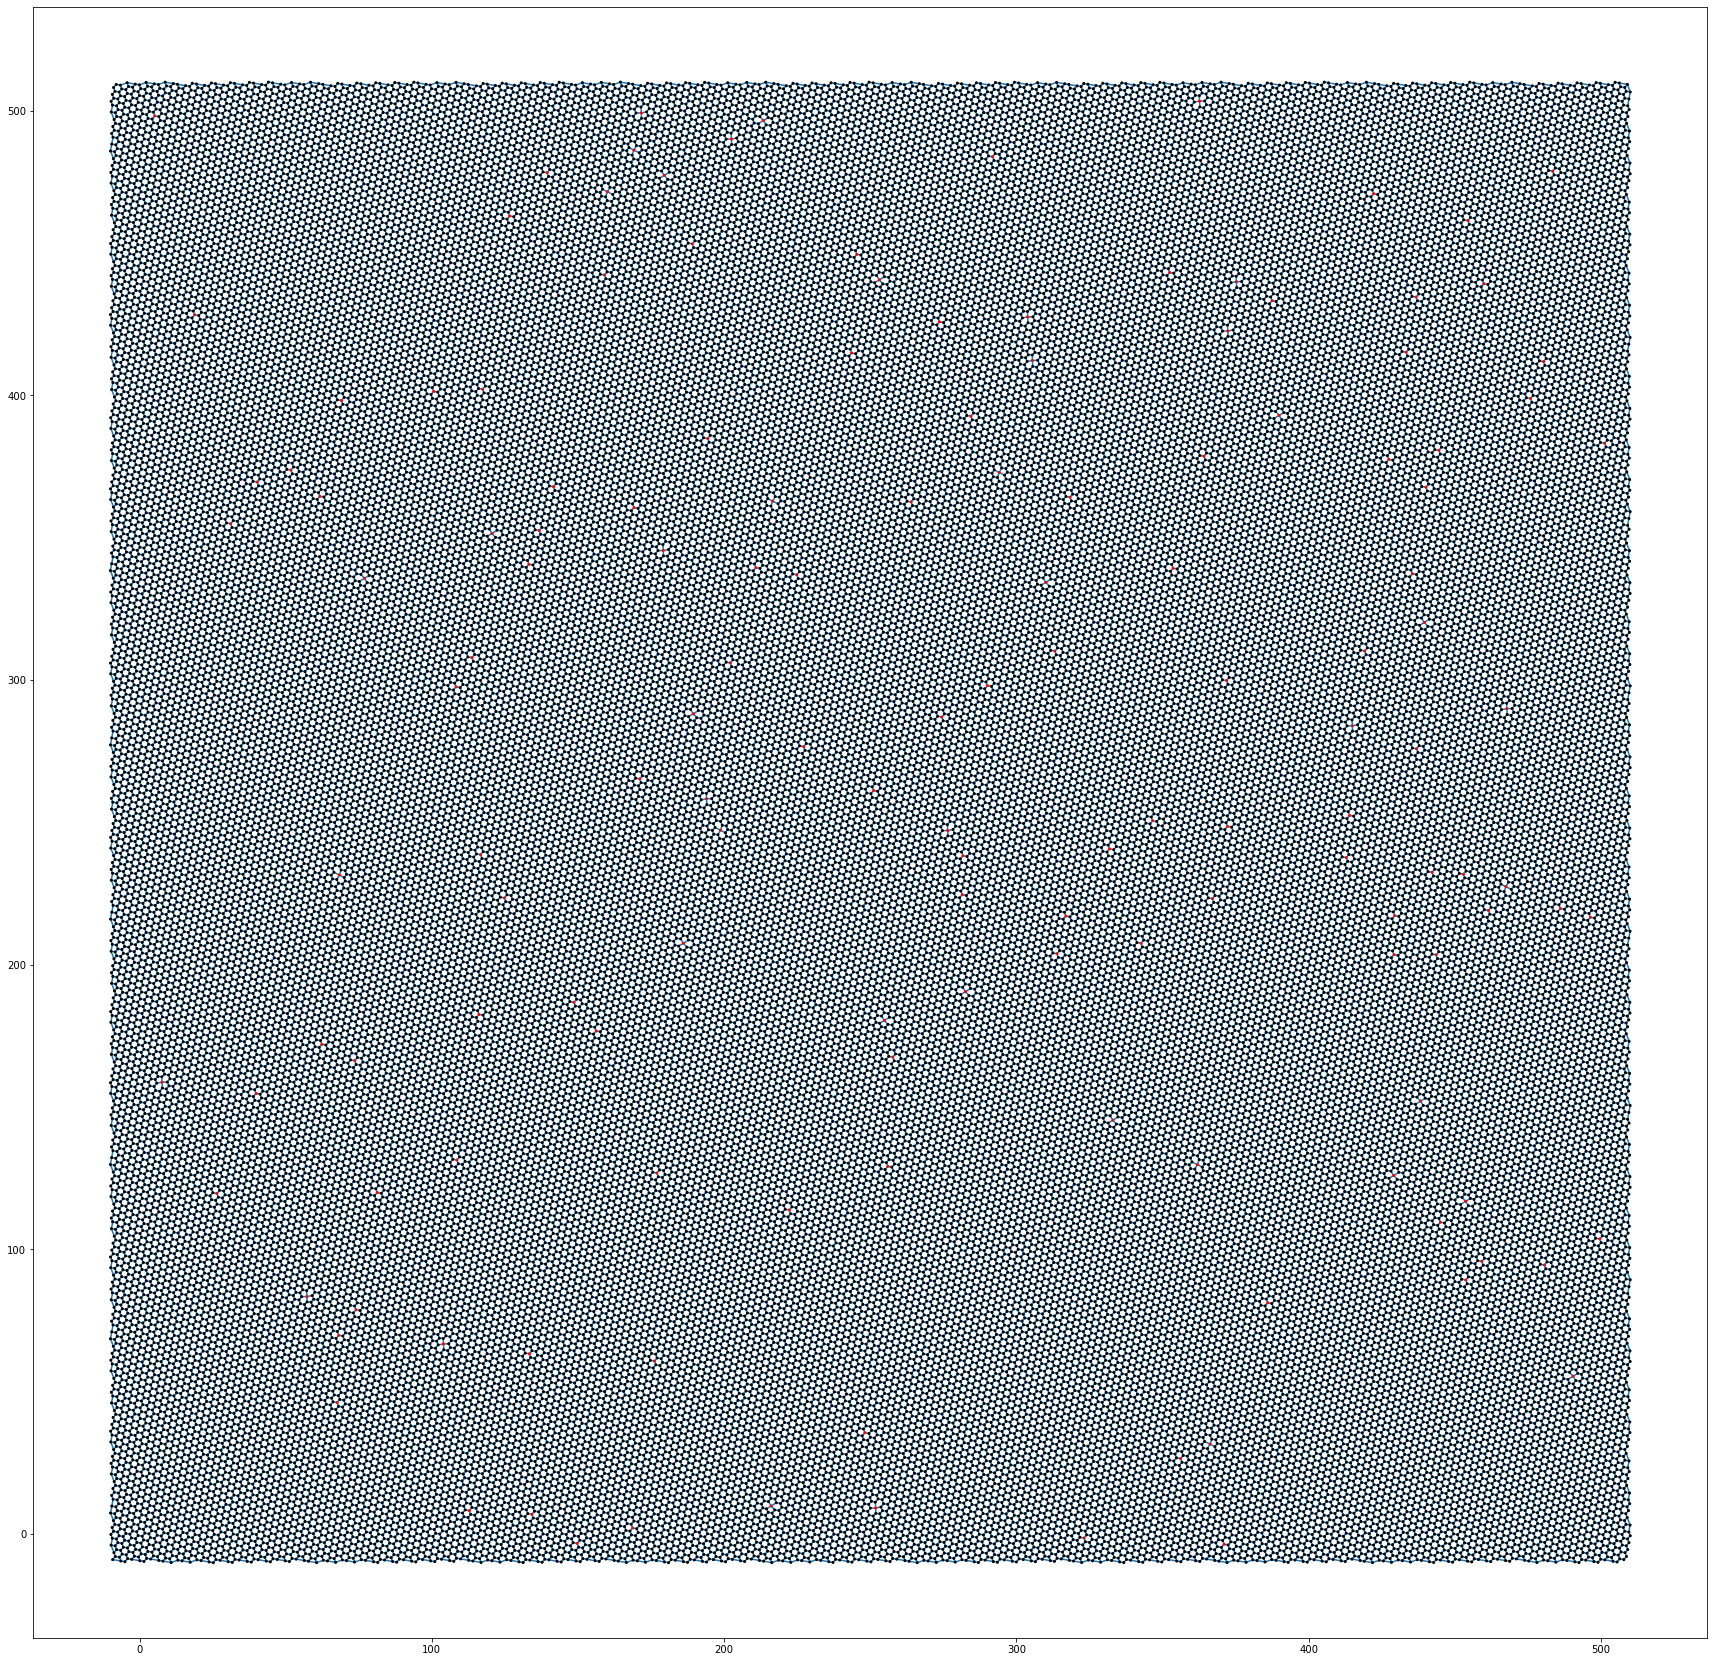

In [28]:
labels = graph.labels
graph = stable_delaunay_graph(graph.points, 2)
graph.set_labels(labels)

fig,ax=plt.subplots(figsize=(30,30))
graph.plot(ax=ax, point_colors={0:'k',1:'red'}, point_kwargs={'s':4})

In [17]:
def bandpass_noise(inner, outer, shape):
    kx = np.fft.fftfreq(shape[0], 1 / shape[0])
    ky = np.fft.fftfreq(shape[1], 1 / shape[1])
    k = np.sqrt(kx[:, None] ** 2 + ky[None] ** 2)
    r = np.random.rand(*k.shape).astype(np.float32)
    mask = ((k > inner) & (k < outer)).astype(np.float32)
    noise = np.fft.fftn(mask * np.exp(-1.j * r * 2 * np.pi), axes=tuple(range(len(k.shape))))
    noise = (noise.real + noise.imag) / 2
    return (noise / (np.std(noise) + 1e-6))

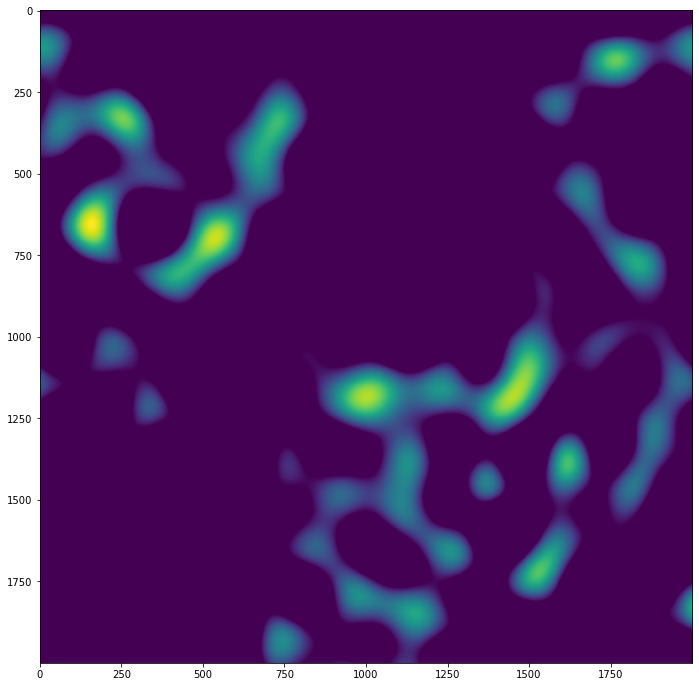

In [24]:
noise = bandpass_noise(0,10,(2000,2000))
noise -= noise.min()
noise = noise ** .5

p = np.zeros_like(noise)
t = 2.
p[noise > t] += noise[noise > t] - t
#noise = bandpass_noise(9,13,np.diag(cell))
#t = 2
#p[noise > t] += noise[noise > t] - t

labelled, n = skimage.measure.label(noise > t, return_num=True)


for i in np.random.randint(n, size=20):
    p[labelled == i] = 0

plt.figure(figsize=(12,12))
plt.imshow(p)

#p = p ** 2

#plt.figure(figsize=(12,12))
#plt.imshow(p)

p = np.array(np.where(np.random.poisson(p))).T / 4
p = p.astype(np.float)
p += np.random.randn(*p.shape)

#print(len(p))

#plt.figure(figsize=(12,12))
#plt.plot(*p.T, 'o')

In [39]:
extent = np.array(np.diag(cell))
sampling = .05
gpts = np.ceil(extent / sampling).astype(np.int)

points = graph.points
#points = p
#points = np.vstack((graph.points, p))

intensities = np.ones(len(points))
intensities[np.where(graph.labels == 1)[0]] = 5
image = gaussian_superposition(points, intensities, extent, .5, gpts)

In [41]:
points = points - points.mean(axis=0)
np.savez('doped_graphene.npz', points=points, intensities=intensities)

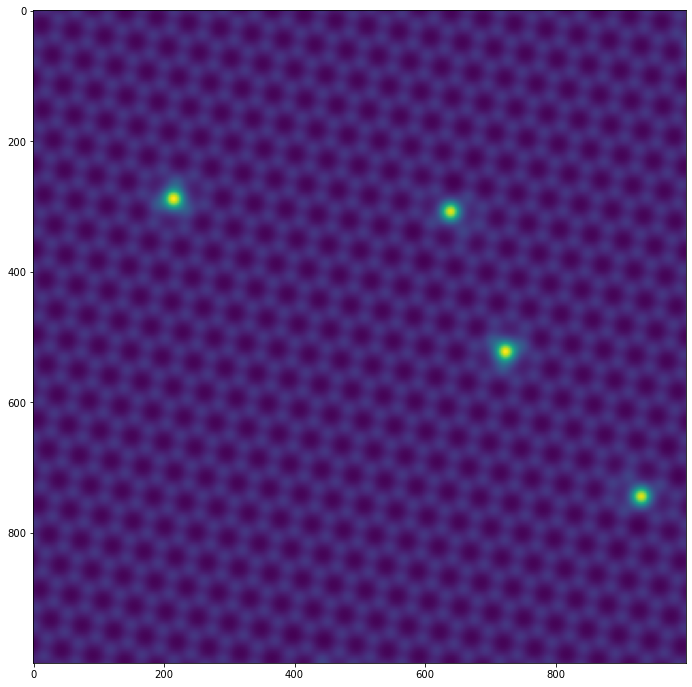

In [40]:
plt.figure(figsize=(12,12))
plt.imshow(image[4500:5500,4500:5500])

#np.save('image.npy', image)